In [1]:
# import stuff
import tensorflow as tf
import numpy as np
tf.enable_eager_execution()
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.contrib.eager as tfe
import matplotlib.gridspec as gridspec

In [2]:
# a simple plotting function which plots 10 exmples along with their predictions
def plot(samples,labels):
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(2, 5)
    gs.update(wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample, cmap='Greys_r')
        number = labels[i].numpy()
        plt.title(str(number))
    return

In [3]:
# load the MNIST data using Keras
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# define a function that scales 0-255 int images to 0-1 float pixel values
def scale(x):
    return tf.to_float(x) / 255.0

In [5]:
# construct a tensorflow Dataset object with iterators that allows going through all the training and test data easily
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(lambda x, y: (scale(x), tf.one_hot(y, 10))).shuffle(10000).batch(30)
test_dsD = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_dsD.map(lambda x, y: (scale(x), tf.one_hot(y, 10))).shuffle(10000).batch(30)

In [6]:
# Construct the model. In the inittialization section we define our layers and in the call we write the forward pass model
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self._input_shape = [-1, 28, 28, 1]
        self.conv1 = tf.layers.Conv2D(32, 5, padding='same', activation=tf.nn.relu)
        self.max_pool2d = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        self.conv2 = tf.layers.Conv2D(64, 5, padding='same', activation=tf.nn.relu)
        self.fc1 = tf.layers.Dense(750, activation=tf.nn.relu)
        self.dropout = tf.layers.Dropout(0.5)
        self.fc2 = tf.layers.Dense(10)
    
    def call(self, x):
        x = tf.reshape(x, self._input_shape)
        x = self.conv1(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.max_pool2d(x)
        x = tf.layers.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        output = self.fc2(x)
        return output

In [7]:
# Define our loss function
def loss_fn(model, x, y):
    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(
          logits=model(x), labels=y))

In [8]:
# An estimate of the accuracy, for the validation and test sets.
def get_accuracy(model, x, y_true):
    logits = model(x)
    prediction = tf.argmax(logits, 1)
    equality = tf.equal(prediction, tf.argmax(y_true, 1))
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    return accuracy

In [11]:
# make an instance of our model
model = MNISTModel()

In [9]:
# make an instance of an optimizer
optimizer = tf.train.AdamOptimizer()

In [12]:
# Train: go through the data, calculate the gradients and apply them to the network weights. As we do this
# we also look at the accuracy of the network prediction for the training data at every 10 steps.
epochs = 100
for (batch, (images, labels)) in enumerate(train_ds):
    with tfe.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())
    if batch % 10 == 0:
        acc = get_accuracy(model, images, labels).numpy()
        print("Iteration {}, loss: {:.3f}, train accuracy: {:.2f}%".format(batch, loss_fn(model, images, labels).numpy(), acc*100))
    if batch > epochs:
        break

Iteration 0, loss: 1.971, train accuracy: 40.00%
Iteration 10, loss: 0.881, train accuracy: 73.33%
Iteration 20, loss: 0.344, train accuracy: 90.00%
Iteration 30, loss: 0.376, train accuracy: 86.67%
Iteration 40, loss: 0.192, train accuracy: 93.33%
Iteration 50, loss: 0.413, train accuracy: 83.33%
Iteration 60, loss: 0.185, train accuracy: 96.67%
Iteration 70, loss: 0.326, train accuracy: 93.33%
Iteration 80, loss: 0.153, train accuracy: 93.33%
Iteration 90, loss: 0.377, train accuracy: 96.67%
Iteration 100, loss: 0.091, train accuracy: 96.67%


Iteration:100, Average test accuracy: 94.67%
Iteration:200, Average test accuracy: 94.35%
Iteration:300, Average test accuracy: 94.20%
Final test accuracy: 94.37%


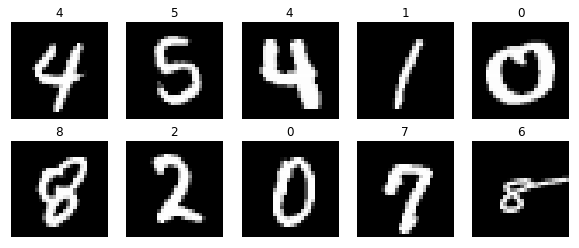

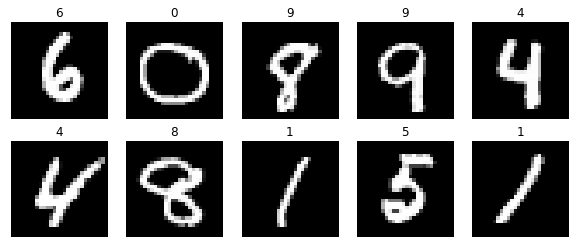

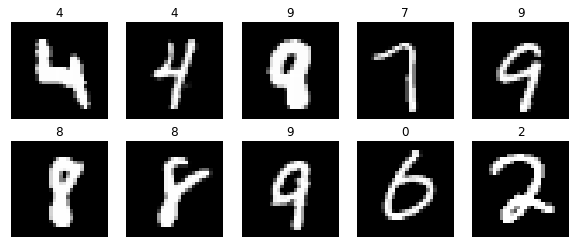

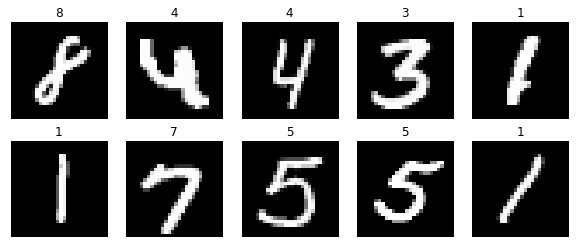

In [14]:
# test the performance of the network on the test set and plot a few examples
avg_acc = 0
for (batch, (images, labels)) in enumerate(test_ds):
    logits = model(images)
    prediction = tf.argmax(logits, 1)
    avg_acc += get_accuracy(model, images, labels).numpy()
    if batch % 100 == 0 and batch != 0:
        plot(images[0:10],prediction[0:10])
        print("Iteration:{}, Average test accuracy: {:.2f}%".format(batch, (avg_acc/batch)*100))
plot(images[0:10],prediction[0:10])
print("Final test accuracy: {:.2f}%".format(avg_acc/batch * 100))
